# XAI - Water Quality in Brisbane


Research question: How can machine learning models predict Dissolved Oxygen levels in water, and what factors most influence these predictions?

## Read and clean dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('../data/brisbane_water_quality.csv')

In [3]:
df.describe()

,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Chlorophyll [quality],Temperature,Temperature [quality],Dissolved Oxygen,Dissolved Oxygen [quality],Dissolved Oxygen (%Saturation),Dissolved Oxygen (%Saturation) [quality],pH,pH [quality],Salinity,Salinity [quality],Specific Conductance,Specific Conductance [quality],Turbidity,Turbidity [quality]
count,30894.000000,30874.000000,30893.000000,30309.000000,30086.000000,25730.000000,25550.000000,26594.000000,26370.000000,25145.000000,24944.000000,29810.000000,29586.0,26936.000000,26712.0,29527.000000,29303.0,28894.000000,28670.0
mean,16914.500000,16.799189,177.544711,2.782251,1020.006648,24.415394,1021.673973,6.815158,1020.488055,96.641207,1022.976668,8.063260,1020.0,31.003265,1020.0,47.927487,1020.0,3.941688,1020.0
std,8918.473945,13.168964,103.621786,1.859404,1.153049,3.494728,40.599400,0.620860,21.976218,8.108339,54.204781,0.091714,0.0,3.469102,0.0,5.155305,0.0,4.072715,0.0
min,1468.000000,0.000000,0.000000,0.100000,1020.000000,17.000000,1020.000000,3.030000,1020.000000,51.836000,1020.000000,7.309000,1020.0,0.057000,1020.0,0.021000,1020.0,0.335000,1020.0
25%,9191.250000,6.594250,86.314000,1.451000,1020.000000,21.292000,1020.000000,6.387000,1020.000000,92.226000,1020.000000,7.980000,1020.0,29.151000,1020.0,45.046000,1020.0,2.354250,1020.0
50%,16914.500000,13.390500,176.326000,2.371000,1020.000000,25.245500,1020.000000,6.814000,1020.000000,96.513000,1020.000000,8.073000,1020.0,30.603500,1020.0,47.420000,1020.0,3.093000,1020.0
75%,24637.750000,23.600000,267.870000,3.650000,1020.000000,27.254000,1020.000000,7.254000,1020.000000,101.668000,1020.000000,8.140000,1020.0,33.918000,1020.0,53.361000,1020.0,4.005000,1020.0
max,32361.000000,89.912000,359.994000,43.301000,1220.000000,32.063000,2010.000000,9.260000,2010.000000,134.082000,2010.000000,8.255000,1020.0,36.000000,1020.0,54.996000,1020.0,49.869000,1020.0


In [4]:
# [quality] columns contain metadata about the quality of the measurement. We however do not have access to what the specific codes actually mean.
# Therefore they have no use to us in this analysis, and we therefore drop them.

df = df.drop(columns=[col for col in df.columns if '[quality]' in col])


In [5]:
# Ensure that Timestamp column is of datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [6]:
# Set Timestamp as index
df = df.set_index('Timestamp')

In [7]:
# All columns should now have the correct datatype (datetime timstamp, int record number, all other are floats)

df.dtypes

Record number                       int64
Average Water Speed               float64
Average Water Direction           float64
Chlorophyll                       float64
Temperature                       float64
Dissolved Oxygen                  float64
Dissolved Oxygen (%Saturation)    float64
pH                                float64
Salinity                          float64
Specific Conductance              float64
Turbidity                         float64
dtype: object

In [8]:
# For some measurements, the values are missing (nan).
print(f"Total number of rows: {df.shape[0]}")
print(f"Number of rows without any NaN values: {df.dropna().shape[0]}")

Total number of rows: 30894
Number of rows without any NaN values: 19373


In [9]:
# We can fill these missing values using interpolation.
# This is a common technique used in time series analysis to fill missing values in time series data. 

df = df.interpolate(method='time')

In [10]:
# Now all rows have values for all columns
print(f"Total number of rows: {df.shape[0]}")
print(f"Number of rows without any NaN values: {df.dropna().shape[0]}")

Total number of rows: 30894
Number of rows without any NaN values: 30894


In [11]:
# Want to include timestamp information as features, in case its relevant for oxygen level
#df['Timestamp'] = df.index.astype(int)
df['MonthOfYear'] = df.index.month
df['DayOfYear'] = df.index.dayofyear



## Exploratory Data Analysis

In [12]:
df

,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity,MonthOfYear,DayOfYear
Timestamp,,,,,,,,,,,,,
2023-08-04 23:00:00,1468,4.834,73.484,1.621,20.018,7.472,101.175,8.176,35.215,53.262,2.068,8,216
2023-08-04 23:30:00,1469,2.544,106.424,1.959,19.986,7.455,100.884,8.175,35.209,53.254,1.994,8,216
2023-08-04 23:00:00,1470,1.260,156.755,1.620,20.001,7.430,100.571,8.171,35.207,53.252,2.030,8,216
2023-08-04 23:30:00,1471,0.760,281.754,1.761,19.983,7.419,100.398,8.171,35.211,53.257,1.973,8,216
2023-08-04 23:00:00,1472,3.397,244.637,1.635,19.986,7.429,100.538,8.171,35.208,53.253,1.944,8,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27 08:20:00,32357,13.314,82.720,0.944,18.607,6.876,87.556,8.151,29.268,45.134,3.963,6,179
2024-06-27 08:30:00,32358,32.617,18.081,1.161,18.551,6.918,87.987,8.163,29.254,45.115,3.928,6,179
2024-06-27 08:40:00,32359,8.552,306.184,1.192,18.558,6.651,84.606,8.145,29.250,45.110,4.097,6,179


### Plot oxygen levels, by time

In [13]:
# Create columns for each unique month, and day.

plot_df = df.copy()

plot_df['Year-Month'] = plot_df.index.to_period('M').astype(str)
plot_df['Year-Month-Day'] = plot_df.index.to_period('D').astype(str)

In [14]:
plot_df

,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity,MonthOfYear,DayOfYear,Year-Month,Year-Month-Day
Timestamp,,,,,,,,,,,,,,,
2023-08-04 23:00:00,1468,4.834,73.484,1.621,20.018,7.472,101.175,8.176,35.215,53.262,2.068,8,216,2023-08,2023-08-04
2023-08-04 23:30:00,1469,2.544,106.424,1.959,19.986,7.455,100.884,8.175,35.209,53.254,1.994,8,216,2023-08,2023-08-04
2023-08-04 23:00:00,1470,1.260,156.755,1.620,20.001,7.430,100.571,8.171,35.207,53.252,2.030,8,216,2023-08,2023-08-04
2023-08-04 23:30:00,1471,0.760,281.754,1.761,19.983,7.419,100.398,8.171,35.211,53.257,1.973,8,216,2023-08,2023-08-04
2023-08-04 23:00:00,1472,3.397,244.637,1.635,19.986,7.429,100.538,8.171,35.208,53.253,1.944,8,216,2023-08,2023-08-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27 08:20:00,32357,13.314,82.720,0.944,18.607,6.876,87.556,8.151,29.268,45.134,3.963,6,179,2024-06,2024-06-27
2024-06-27 08:30:00,32358,32.617,18.081,1.161,18.551,6.918,87.987,8.163,29.254,45.115,3.928,6,179,2024-06,2024-06-27
2024-06-27 08:40:00,32359,8.552,306.184,1.192,18.558,6.651,84.606,8.145,29.250,45.110,4.097,6,179,2024-06,2024-06-27


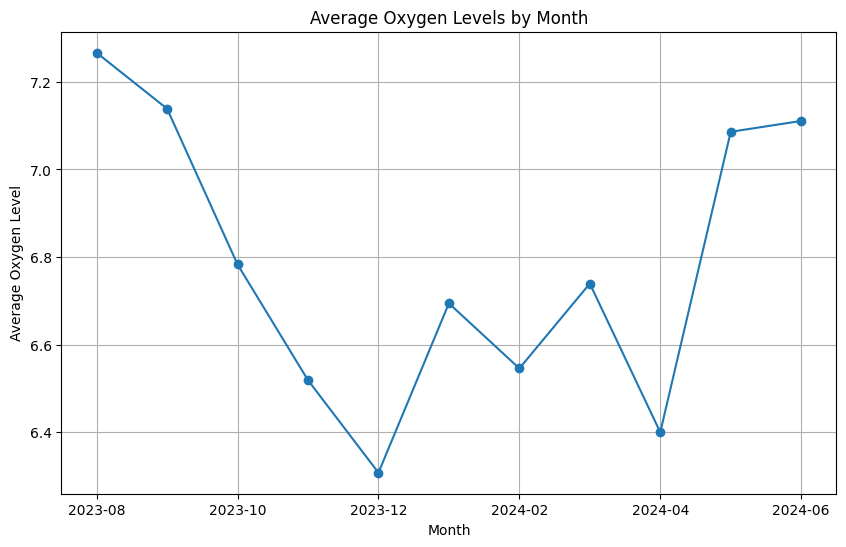

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by month and calculate the mean Dissolved Oxygen for each month
monthly_oxygen_levels = plot_df.groupby('Year-Month')['Dissolved Oxygen'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
monthly_oxygen_levels.plot(kind='line', marker='o')
plt.title('Average Oxygen Levels by Month')
plt.xlabel('Month')
plt.ylabel('Average Oxygen Level')
plt.grid(True)
plt.show()

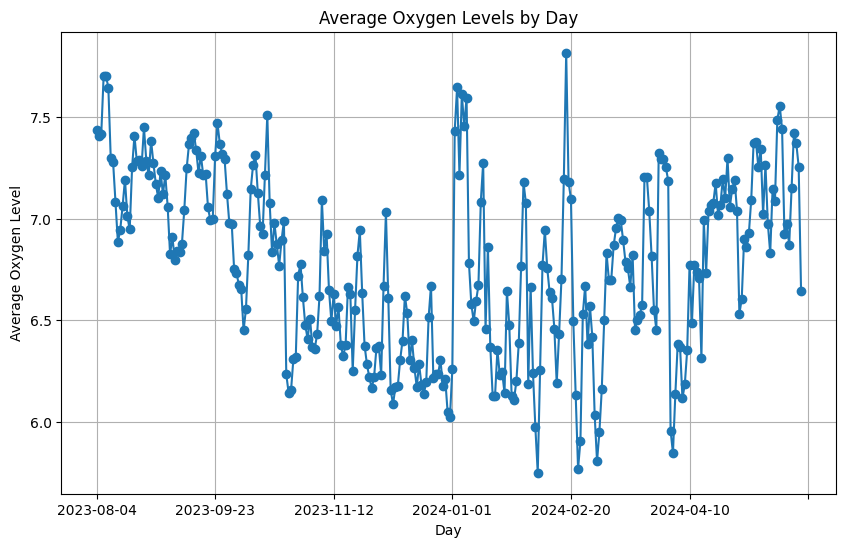

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by day and calculate the mean Dissolved Oxygen for each day
daily_oxygen_levels = plot_df.groupby('Year-Month-Day')['Dissolved Oxygen'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
daily_oxygen_levels.plot(kind='line', marker='o')
plt.title('Average Oxygen Levels by Day')
plt.xlabel('Day')
plt.ylabel('Average Oxygen Level')
plt.grid(True)
plt.show()

### Features correlated with oxygen

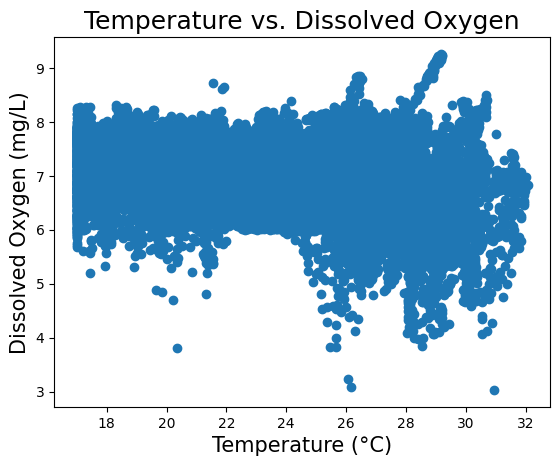

In [17]:
#plot 1: How tamperature affects Dissolved Oxygen
plt.scatter(df['Temperature'], df['Dissolved Oxygen'])
plt.xlabel ('Temperature (°C)', size=15)
plt.ylabel ('Dissolved Oxygen (mg/L)', size=15)
plt.title ('Temperature vs. Dissolved Oxygen', size=18)
plt.show()

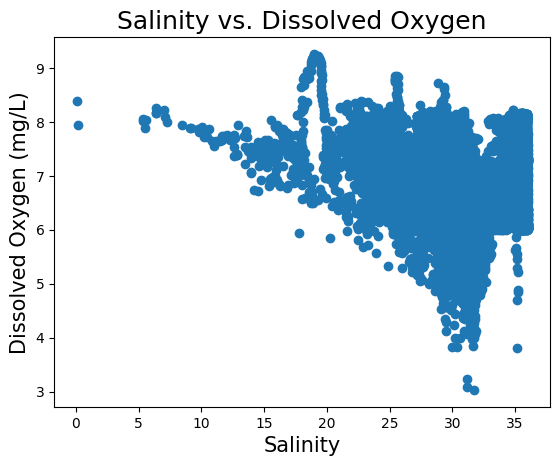

In [18]:
plt.scatter(df['Salinity'], df['Dissolved Oxygen'])
plt.xlabel ('Salinity', size =15)
plt.ylabel('Dissolved Oxygen (mg/L)', size=15)
plt.title ('Salinity vs. Dissolved Oxygen', size=18)
plt.show()

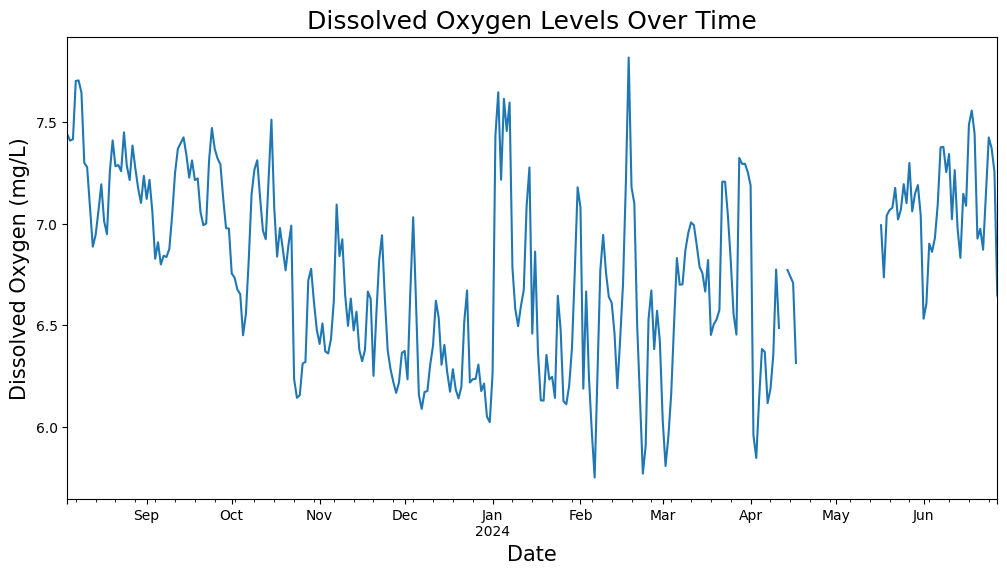

In [19]:
df.resample('D').mean()['Dissolved Oxygen'].plot(figsize=(12,6))
plt.xlabel('Date', size=15)
plt.ylabel('Dissolved Oxygen (mg/L)', size=15)
plt.title('Dissolved Oxygen Levels Over Time', size=18)
plt.show()

### Correlation Matrix

In order to investigate how different features of the dataset relates eachother, we can create a correlation matrix.

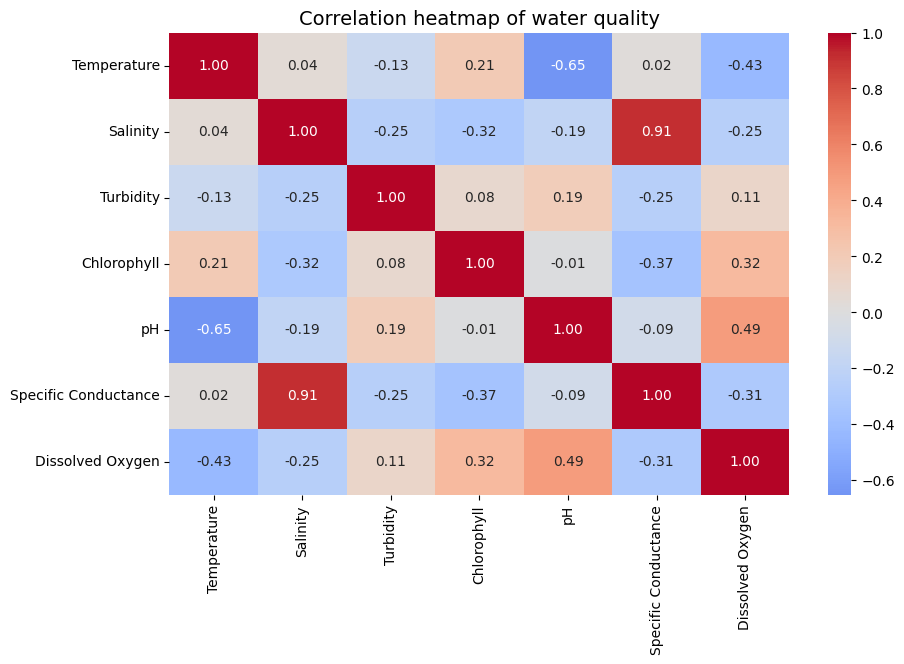

In [20]:
features =[ "Temperature", "Salinity", "Turbidity", "Chlorophyll", "pH", "Specific Conductance", "Dissolved Oxygen" ]

correlation_matrix = df[features].corr()

#Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Correlation heatmap of water quality", fontsize=14)
plt.show()

A positive correlation (closer to +1), that indicates the one feature increases, the other increases. For example

While the negative correlation (closer to -1) means that as one feature increases, the other decreases. For instance, higher tempratures is likely reduced dissolved oxygen levels.

A correlation close to 0 suggest that it is a weak or no relashionship between the features, meaning that changes in one feture do not significantly affect the other.

## Model

In [21]:
from sklearn.model_selection import train_test_split

# X are features. 
# We remove Dissolved Oxygen (target) and Dissolved Oxygen (%Saturation), as it is a derived value.
# We also remove RecordNumber as it is just an index.

X = df.drop(columns=['Dissolved Oxygen', 'Dissolved Oxygen (%Saturation)', 'Record number'])
# Y are the target value - we want to predict amount of Dissolved Oxygen
y = df['Dissolved Oxygen']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Liner Regression

In [22]:
from sklearn.linear_model  import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

#### Random Forest Regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Evalute model against test data

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def eval_model(model):
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')

In [25]:
eval_model(model_lr)

Mean Squared Error: 0.20708801578905048
Mean Absolute Error: 0.3473173271568557


In [26]:
eval_model(model_rfr)

Mean Squared Error: 0.031236848721364462
Mean Absolute Error: 0.11464273236713803


## XAI Methods

### Shap (Shapley Additive Explanations)


#### Setup - Computing shap values, and plots

In [27]:
import shap
shap.initjs()

# Compute SHAP values for model
def shap_get_values(model):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    return shap_values

# Local prediction plots
def shap_local_plot(shap_values):
    shap.plots.waterfall(shap_values[0])
    shap.plots.force(shap_values[0])

# Global prediction plots
def shap_global_plot(shap_values):
    # force plot is slow for many rows, use a smaller sample
    sample = shap.utils.sample(shap_values, 100)

    shap.plots.force(sample)
    shap.plots.bar(shap_values)
    shap.plots.beeswarm(shap_values)
    shap.plots.scatter(shap_values[:,"Temperature"])


d:\Code\INFO381-XAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Linear regression model

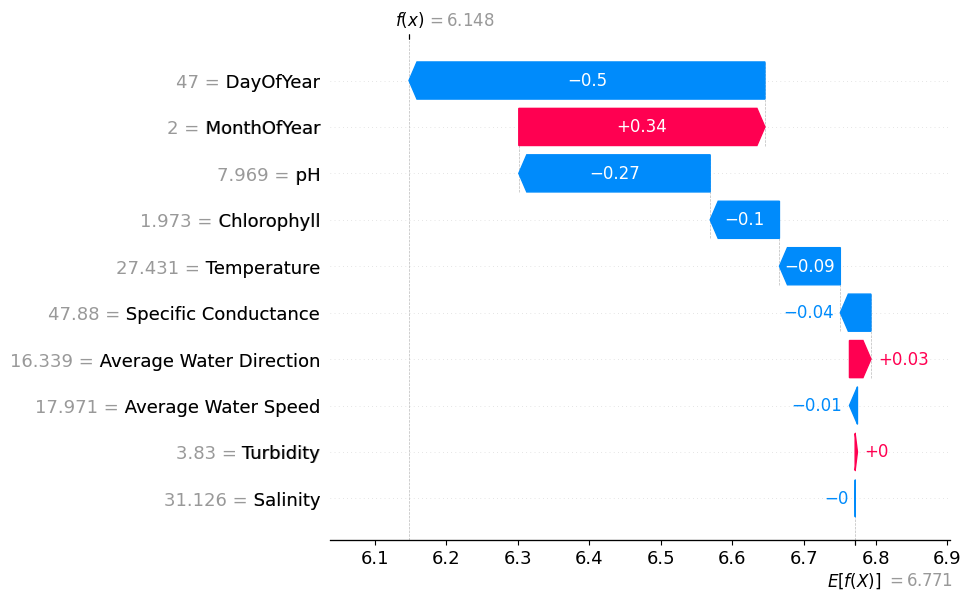

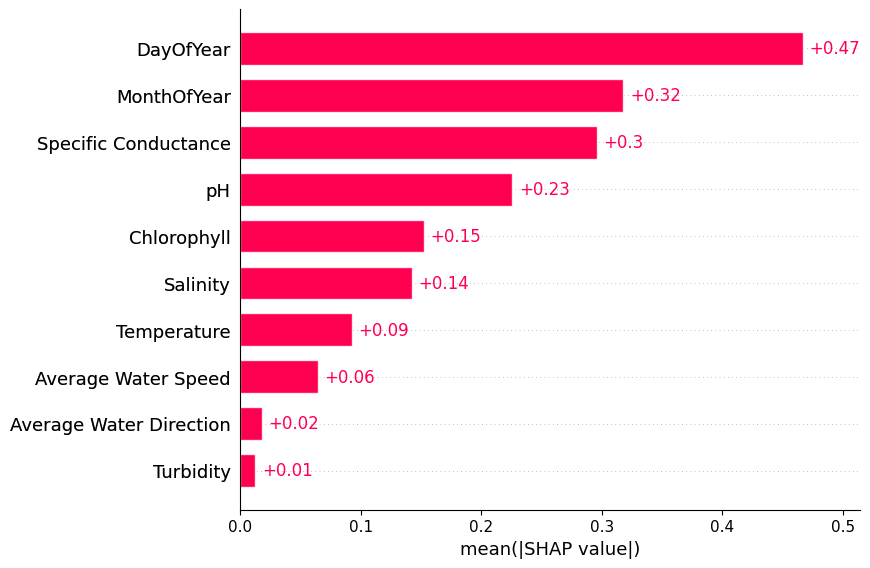

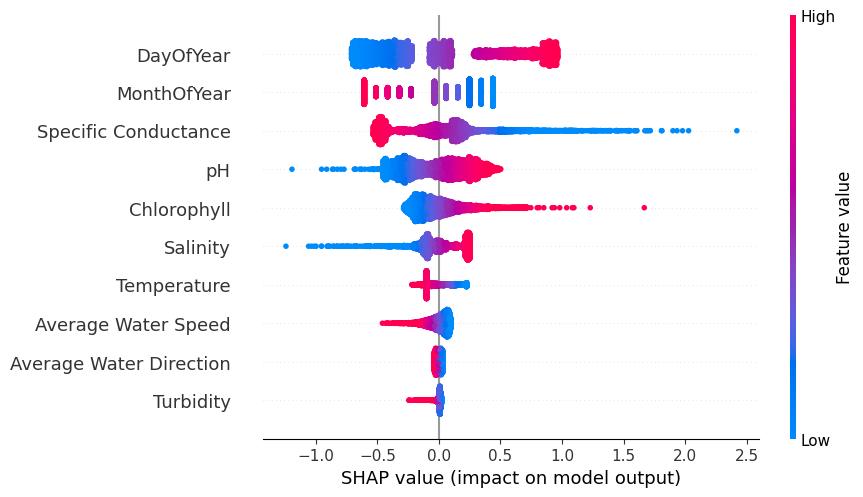

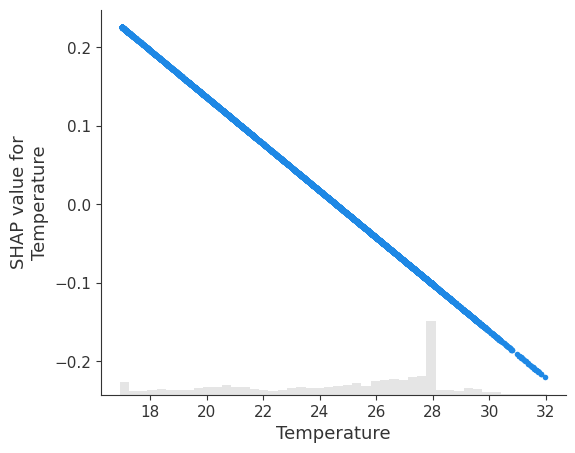

In [28]:
shap_values_lr = shap_get_values(model_lr)

shap_local_plot(shap_values_lr)
shap_global_plot(shap_values_lr)

#### Random Forest Regressor

In [63]:
shap_values_rfr = shap_get_values(model_rfr)

shap_local_plot(shap_values_rfr)
shap_global_plot(shap_values_rfr)

100%|===================| 6168/6179 [05:52<00:00]        

### LIME 